In [114]:
from bs4 import BeautifulSoup
import json
import pandas as pd
import requests


url = 'https://www.imdb.com/title/tt0417299/'
main_page = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
main_soup = BeautifulSoup(main_page.content, 'html.parser')

n_episodes = main_soup.find_all('span', class_='ipc-title__subtext')[0].text

seasons_html = main_soup.find('label', class_='ipc-simple-select__label')
n_seasons = int(seasons_html.text.split(' ')[0])

seasons_urls = ['https://www.imdb.com/title/tt0417299/episodes?season={}'.format(n+1) for n in range(n_seasons)]

full_dataset_df = pd.DataFrame()

for season in seasons_urls:
	season_num = int(season[-1])

	season_page = requests.get(season, headers={'User-Agent': 'Mozilla/5.0'})
	season_soup = BeautifulSoup(season_page.content, 'html.parser')

	episodes_number_html = season_soup.find_all('div', class_='zero-z-index')
	episodes_number = [int(block.div.text.split('Ep')[1]) for block in episodes_number_html]

	episode_title_html = season_soup.find_all('a', itemprop='name')
	episodes_title = [block.text for block in episode_title_html]

	episode_rating_html = season_soup.find_all('span', class_='ipl-rating-star__rating')
	episodes_rating = [round(float(block.text), 1) for block in episode_rating_html if '.' in block.text]

	episode_votes_html = season_soup.find_all('span', class_='ipl-rating-star__total-votes')
	episodes_votes = [int(block.text[1:-1].replace(',', '')) for block in episode_votes_html]

	if season_num == 1:
		episodes_number = episodes_number[1:]
		episodes_title = episodes_title[1:]
		episodes_rating = episodes_rating[1:]
		episodes_votes = episodes_votes[1:]

	assert len(episodes_number) == len(episodes_title)
	assert len(episodes_title) == len(episodes_rating)
	assert len(episodes_rating) == len(episodes_votes)

	data = {'season': season_num,
			'episode': episodes_number,
			'title': episodes_title,
			'rating': episodes_rating,
			'votes': episodes_votes
			}
    
	season_df = pd.DataFrame.from_dict(data)

	full_dataset_df = pd.concat([full_dataset_df, season_df])

[<div class="text show-more__control">OK, so I was 12 when this show came out and needless to say, I was completely enamored by it. For a TV station like Nickelodeon, best known for its wacky shows like SpongeBob, Rocko's Modern Life and their sitcoms like Drake and Josh, to suddenly come out with this anime-inspired animated series with deep philosophical themes as well as tackling genocide and war, this was a massive step forward.<br/><br/>Of course, this isn't the first form of media that has incorporated the power of the elements, but their method of how they do it here is remarkable. For every element to be adopted into its own nation, reflecting the psyches and philosophies attributed to the respective element is truly inspiring.<br/><br/>All the characters are written for and performed expertly, save for maybe some of the guest characters (*cough cough* Jet). My favourite character by far is Zuko. The progression and development of this character is incredible and captures perfe

In [120]:
additional_data = {}

data_json = main_soup.find_all('script', id="__NEXT_DATA__")[0]
data_attributes = json.loads(data_json.text)['props']['pageProps']['aboveTheFoldData']

# Overall Rating
overall_rating = data_attributes['ratingsSummary']['aggregateRating']
additional_data['overall_rating'] = overall_rating

# Overall Votes
overall_votes = data_attributes['ratingsSummary']['voteCount']
additional_data['overall_votes'] = overall_votes

# Episode Runtime data_attributes['runtime']['seconds']
runtime = str(int(data_attributes['runtime']['seconds'] / 60)) + 'min.'
additional_data['runtime'] = runtime

# Series Genres
genres = [item['text'] for item in data_attributes['genres']['genres']]
additional_data['genres'] = [genres]

# Country of Origin
country_of_origin = data_attributes['countriesOfOrigin']['countries'][0]['id']
additional_data['country_of_origin'] = country_of_origin

# Air Dates (Years)
start_year = data_attributes['releaseYear']['year']
end_year = data_attributes['releaseYear']['endYear']
additional_data['start_year'] = start_year
additional_data['end_year'] = end_year

# Poster Image
poster_image = data_attributes['primaryImage']['url']
additional_data['poster_image'] = poster_image

# Credits (Creators/Directors/Production Company/Writers)
show_creators = [credit['name']['nameText']['text'] for credit in data_attributes['creatorsPageTitle'][0]['credits']]
production_company = data_attributes['production']['edges'][0]['node']['company']['companyText']['text']
additional_data['show_creators'] = [show_creators]
additional_data['production_company'] = production_company

# Total Amount of Reviews
n_reviews = data_attributes['reviews']['total']
additional_data['n_reviews'] = n_reviews

# Plot
plot_text = data_attributes['plot']['plotText']['plainText']
additional_data['plot_text'] = plot_text

# Original Title
original_title = data_attributes['originalTitleText']['text']
additional_data['original_title'] = original_title
print(additional_data)
additional_df = pd.DataFrame.from_dict(additional_data)
additional_df

{'overall_rating': 9.3, 'overall_votes': 328452, 'runtime': '23min.', 'genres': [['Animation', 'Action', 'Adventure', 'Family', 'Fantasy', 'Mystery']], 'country_of_origin': 'US', 'start_year': 2005, 'end_year': 2008, 'poster_image': 'https://m.media-amazon.com/images/M/MV5BODc5YTBhMTItMjhkNi00ZTIxLWI0YjAtNTZmOTY0YjRlZGQ0XkEyXkFqcGdeQXVyODUwNjEzMzg@._V1_.jpg', 'show_creators': [['Michael Dante DiMartino', 'Bryan Konietzko']], 'production_company': 'Nickelodeon Animation Studios', 'n_reviews': 893, 'plot_text': 'In a war-torn world of elemental magic, a young boy reawakens to undertake a dangerous mystic quest to fulfill his destiny as the Avatar, and bring peace to the world.', 'original_title': 'Avatar: The Last Airbender'}


,overall_rating,overall_votes,runtime,genres,country_of_origin,start_year,end_year,poster_image,show_creators,production_company,n_reviews,plot_text,original_title
0,9.3,328452,23min.,"[Animation, Action, Adventure, Family, Fantasy...",US,2005,2008,https://m.media-amazon.com/images/M/MV5BODc5YT...,"[Michael Dante DiMartino, Bryan Konietzko]",Nickelodeon Animation Studios,893,"In a war-torn world of elemental magic, a youn...",Avatar: The Last Airbender


In [131]:
# Review Titles and Texts for Word Cloud
# Source: https://stackoverflow.com/questions/68243944/collecting-all-movie-reviews-from-imdb-from-certain-dramas
start_url = 'https://www.imdb.com/title/tt0417299/reviews'
link = 'https://www.imdb.com/title/tt0417299/reviews/_ajax'

params = {
     	  'ref_': 'undefined',
		  'paginationKey': ''
         }

reviews = {'review_title': [], 'review_text': []}

with requests.Session() as session:
    result = session.get(start_url, headers={'User-Agent': 'Mozilla/5.0'})

    while True:
        soup = BeautifulSoup(result.text,'html.parser')
        for item in soup.select('.review-container'):
            review_title = item.find_all('a', class_='title')[0].text.strip()
            review_text = item.find_all('div', class_='text show-more__control')[0].text.strip().replace("n\\'t", "n't")

            reviews['review_title'].append(review_title)
            reviews['review_text'].append(review_text)

        try:
            pagination_key = soup.select_one('.load-more-data[data-key]').get('data-key')
        except AttributeError:
            break
        params['paginationKey'] = pagination_key
        result = session.get(link, params=params)

reviews_df = pd.DataFrame(data=reviews)
reviews_df

,review_title,review_text
0,The best show Nickelodeon has aired,"OK, so I was 12 when this show came out and ne..."
1,One of the best animated shows I seen,This is a anime style cartoon that kids and ad...
2,"Great show with fantastic messages, lessons, p...",This is show is one of the best shows ever cre...
3,I just rewatched the best TV series in the his...,"Hi there.It is September 2016, more than a dec..."
4,"not just a great animated show or 'kids' show,...",Avatar The Last Airbender shouldn't be underes...
...,...,...
886,Different from the other shows on Nickelodeon,"""Avatar"" is very different from the many noned..."
887,Greatest show I've ever watched,"From world building to character development, ..."
888,Complexity for children.,I remember watching the series premier of this...
889,Toph,I saw a clip talk about Toph Beifong on youtub...


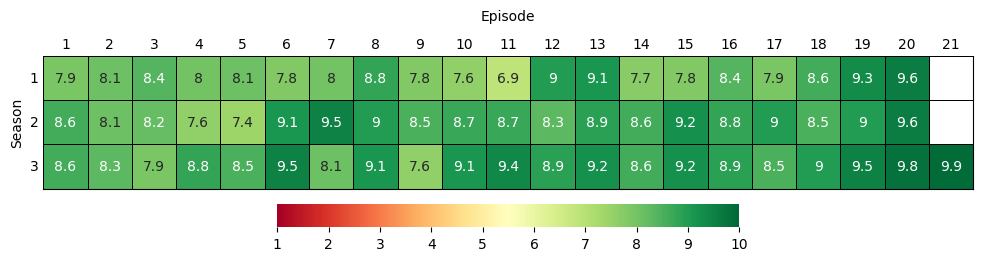

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

subset_df = full_dataset_df.copy()[['season', 'episode', 'rating']]
pivoted_subset_df = subset_df.pivot(index=['season'], columns='episode')

fig, ax = plt.subplots(figsize=(12,10))

sns.heatmap(data=pivoted_subset_df,
            vmin=1,
            vmax=10,
            cmap='RdYlGn',
            square=True,
            annot=True,
            cbar=True,
            linecolor='black',
            linewidth=0.5,
            cbar_kws={'location': 'bottom', 'fraction': 0.03, 'pad': 0.02}
            )

ax.set_xlabel('Episode', labelpad=12)
ax.xaxis.set_label_position('top')
ax.set_xticklabels([label.get_text().split('-')[1] for label in ax.get_xticklabels()])
ax.tick_params(axis='x', labelrotation=0, length=0, labeltop=True, labelbottom=False)
ax.set_ylabel('Season')
ax.tick_params(axis='y', labelrotation=0, length=0)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)

plt.show()
plt.close()

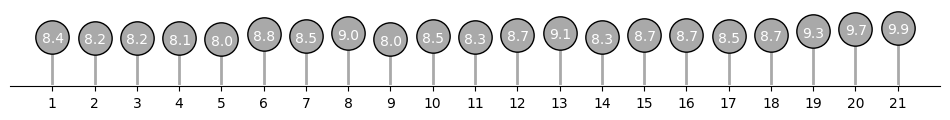

In [147]:
season_average = pivoted_subset_df.mean(axis=1)
episode_average = pivoted_subset_df.mean(axis=0)

fig, ax = plt.subplots(figsize=(12, 1))

plt.stem(episode_average,
         label=episode_average,
         basefmt='white'
         )

for c, child in enumerate(ax.get_children()):
    if c == 0: #stem lines
        child.set_color('darkgray')
        child.set_linewidth(2)
    elif c == 1: # marker lines
        child.set_markerfacecolor('darkgray')
        child.set_markeredgecolor('black')
        child.set_markersize(24)

ax.set_xlim(-1, 21)
ax.set_xticks(range(0, 21))
ax.set_xticklabels(range(1, 22))
ax.set_ylim(0, 13)
ax.set_yticklabels([])
ax.tick_params(axis='y', length=0)
ax.spines[['left', 'top', 'right']].set_visible(False)

rounded_episode_average = episode_average.copy().values.round(decimals=1)
for i, rounded_average in enumerate(rounded_episode_average):
    ax.annotate(str(rounded_average), xy=(i-0.25,rounded_average-1), color='white')

plt.show()
plt.close()

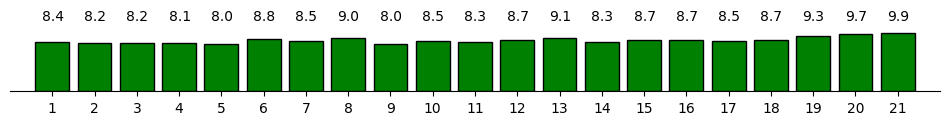

In [320]:
season_average = pivoted_subset_df.mean(axis=1).reset_index().rename(columns={0: 'rating'})
episode_average = pivoted_subset_df.mean(axis=0).reset_index().drop(columns=['level_0']).rename(columns={0: 'rating'})

bar_colors = []
for rating in episode_average['rating']:
    rounded_rating = round(rating, 1)
    if rounded_rating >= 8.0:
        bar_colors.append('green')
    elif 6.0 <= rounded_rating < 8.0:
        bar_colors.append('lightgreen')
    elif 4.0 <= rounded_rating < 6.0:
        bar_colors.append('gold')
    elif 2.0 <= rounded_rating < 4.0:
        bar_colors.append('orange')
    else:
        bar_colors.append('red')

fig, ax = plt.subplots(figsize=(12, 1))

sns.barplot(data=episode_average,
            x='episode',
            y='rating'
            )

for c, child in enumerate(ax.get_children()):
    if c < episode_average['episode'].max():
        child.set_color(bar_colors[c])
        child.set_edgecolor('black')
    else:
        break

ax.set_xlim(-1, 21)
ax.set_xlabel('')
ax.set_ylim(0, 13)
ax.set_ylabel('')
ax.set_yticklabels([])
ax.tick_params(axis='y', length=0)
ax.spines[['left', 'top', 'right']].set_visible(False)

rounded_episode_average = episode_average.copy()['rating'].values.round(decimals=1)
for i, rounded_average in enumerate(rounded_episode_average):
    ax.annotate(str(rounded_average), xy=(i-0.25,12), color='black')

plt.show()
plt.close()

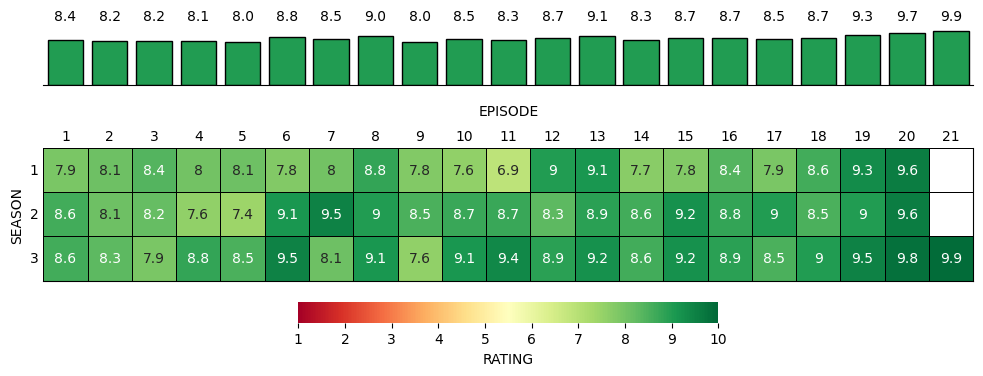

In [401]:
import matplotlib.pyplot as plt
import seaborn as sns

subset_df = full_dataset_df.copy()[['season', 'episode', 'rating']]
pivoted_subset_df = subset_df.pivot(index=['season'], columns='episode')

season_average = pivoted_subset_df.mean(axis=1).reset_index().rename(columns={0: 'rating'})
episode_average = pivoted_subset_df.mean(axis=0).reset_index().drop(columns=['level_0']).rename(columns={0: 'rating'})

fig, axes = plt.subplots(nrows=2,
                         ncols=1,
                         sharex=True,
                         figsize=(12,4),
                         gridspec_kw={'height_ratios': [0.25, 0.75]}
                         )

bar_colors = []
for rating in episode_average['rating']:
    rounded_rating = round(rating, 1)
    if rounded_rating >= 8.0:
        bar_colors.append('#219C52')
    elif 6.0 <= rounded_rating < 8.0:
        bar_colors.append('#BDE379')
    elif 4.0 <= rounded_rating < 6.0:
        bar_colors.append('#FEDF8A')
    elif 2.0 <= rounded_rating < 4.0:
        bar_colors.append('#F7854E')
    else:
        bar_colors.append('#BB1526')

sns.barplot(data=episode_average,
            x='episode',
            y='rating',
            ax=axes[0]
            )

for c, child in enumerate(axes[0].get_children()):
    if c < episode_average['episode'].max():
        child.set_color(bar_colors[c])
        child.set_edgecolor('black')
        current_x = child.get_x()
        child.set_x(current_x + 0.5)
    else:
        break

axes[0].set_xlim(-1, 21)
axes[0].set_xlabel('')
axes[0].set_ylim(0, 13)
axes[0].set_ylabel('')
axes[0].set_yticklabels([])
axes[0].tick_params(axis='both', length=0)
axes[0].spines[['left', 'top', 'right']].set_visible(False)

rounded_episode_average = episode_average.copy()['rating'].values.round(decimals=1)
for i, rounded_average in enumerate(rounded_episode_average):
    axes[0].annotate(str(rounded_average), xy=(i+0.25,12), color='black')

sns.heatmap(data=pivoted_subset_df,
            vmin=1,
            vmax=10,
            cmap='RdYlGn',
            square=True,
            annot=True,
            cbar=True,
            linecolor='black',
            linewidth=0.5,
            cbar_kws={'location': 'bottom', 'label': 'RATING', 'fraction': 0.1, 'pad': 0.1},
            ax=axes[1]
            )

axes[1].set_xlabel('EPISODE', labelpad=10)
axes[1].xaxis.set_label_position('top')
axes[1].set_xticklabels([label.get_text().split('-')[1] for label in axes[1].get_xticklabels()])
axes[1].tick_params(axis='x', labelrotation=0, length=0, labeltop=True, labelbottom=False)
axes[1].set_ylabel('SEASON')
axes[1].tick_params(axis='y', labelrotation=0, length=0)
axes[1].spines['right'].set_visible(True)
axes[1].spines['bottom'].set_visible(True)

plt.show()
plt.close()

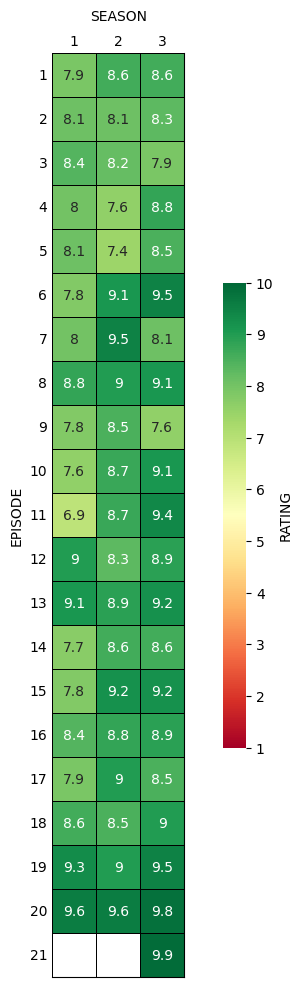

In [419]:
import matplotlib.pyplot as plt
import seaborn as sns

subset_df = full_dataset_df.copy()[['season', 'episode', 'rating']]
pivoted_subset_df = subset_df.pivot(index=['episode'], columns='season')

episode_average = pivoted_subset_df.mean(axis=1).reset_index().rename(columns={0: 'rating'})
season_average = pivoted_subset_df.mean(axis=0).reset_index().drop(columns=['level_0']).rename(columns={0: 'rating'})

fig, ax = plt.subplots(figsize=(10,12))

sns.heatmap(data=pivoted_subset_df,
            vmin=1,
            vmax=10,
            cmap='RdYlGn',
            square=True,
            annot=True,
            cbar=True,
            linecolor='black',
            linewidth=0.5,
            cbar_kws={'location': 'right', 'label': 'RATING', 'fraction': 0.03}
            )

ax.set_xlabel('SEASON', labelpad=10)
ax.xaxis.set_label_position('top')
ax.set_xticklabels([label.get_text().split('-')[1] for label in ax.get_xticklabels()])
ax.tick_params(axis='x', labelrotation=0, length=0, labeltop=True, labelbottom=False)
ax.set_ylabel('EPISODE')
ax.tick_params(axis='y', labelrotation=0, length=0)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)

plt.show()
plt.close()

C:\Users\migue\AppData\Local\Temp\ipykernel_15992\1134337460.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


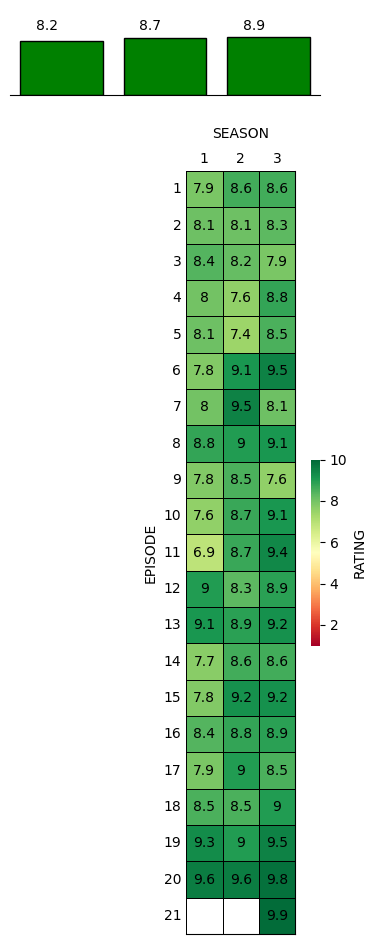

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

subset_df = full_dataset_df.copy()[['season', 'episode', 'rating']]
pivoted_subset_df = subset_df.pivot(index=['episode'], columns='season')

episode_average = pivoted_subset_df.mean(axis=1).reset_index().rename(columns={0: 'rating'})
season_average = pivoted_subset_df.mean(axis=0).reset_index().drop(columns=['level_0']).rename(columns={0: 'rating'})

fig, axes = plt.subplots(nrows=2,
                         ncols=1,
                         sharex=True,
                         figsize=(4,12),
                         gridspec_kw={'height_ratios': [0.10, 0.90], 'hspace': 0.18}
                         )

bar_colors = []
for rating in season_average['rating']:
    rounded_rating = round(rating, 1)
    if rounded_rating >= 8.0:
        bar_colors.append('green')
    elif 6.0 <= rounded_rating < 8.0:
        bar_colors.append('lightgreen')
    elif 4.0 <= rounded_rating < 6.0:
        bar_colors.append('gold')
    elif 2.0 <= rounded_rating < 4.0:
        bar_colors.append('orange')
    else:
        bar_colors.append('red')

sns.barplot(data=season_average,
            x='season',
            y='rating',
            ax=axes[0]
            )

for c, child in enumerate(axes[0].get_children()):
    if c < season_average['season'].max():
        child.set_color(bar_colors[c])
        child.set_edgecolor('black')
        current_x = child.get_x()
        child.set_x(current_x + 0.5)
    else:
        break

axes[0].set_xlim(-1, 3)
axes[0].set_xlabel('')
axes[0].set_ylim(0, 13)
axes[0].set_ylabel('')
axes[0].set_yticklabels([])
axes[0].tick_params(axis='both', length=0)
axes[0].spines[['left', 'top', 'right']].set_visible(False)

rounded_season_average = season_average.copy()['rating'].values.round(decimals=1)
for i, rounded_average in enumerate(rounded_season_average):
    axes[0].annotate(str(rounded_average), xy=(i+0.25,10), color='black')

sns.heatmap(data=pivoted_subset_df,
            vmin=1,
            vmax=10,
            cmap='RdYlGn',
            square=True,
            annot=True,
            annot_kws={'color': 'black'},
            cbar=True,
            linecolor='black',
            linewidth=0.5,
            cbar_kws={'location': 'right', 'label': 'RATING', 'fraction': 0.03},
            ax=axes[1]
            )

axes[1].set_xlabel('SEASON', labelpad=10)
axes[1].xaxis.set_label_position('top')
axes[1].set_xticklabels([label.get_text().split('-')[1] for label in axes[1].get_xticklabels()])
axes[1].tick_params(axis='x', labelrotation=0, length=0, labeltop=True, labelbottom=False)
axes[1].set_ylabel('EPISODE')
axes[1].tick_params(axis='y', labelrotation=0, length=0)
axes[1].spines['right'].set_visible(True)
axes[1].spines['bottom'].set_visible(True)

plt.tight_layout()

plt.show()
plt.close()

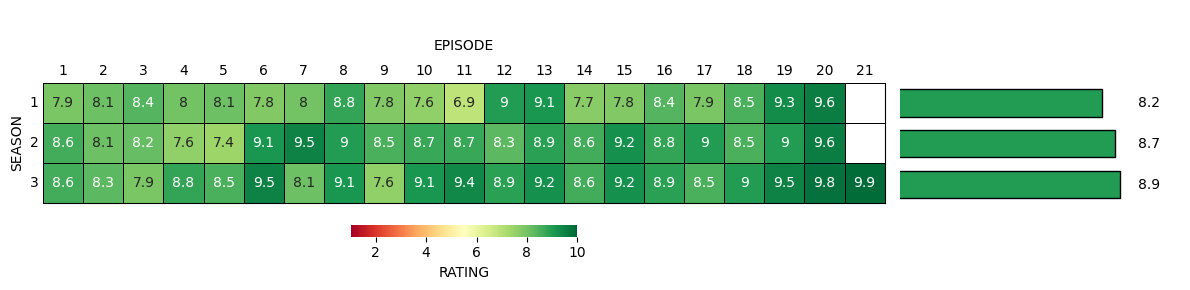

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns

subset_df = full_dataset_df.copy()[['season', 'episode', 'rating']]
pivoted_subset_df = subset_df.pivot(index=['season'], columns='episode')

season_average = pivoted_subset_df.mean(axis=1).reset_index().rename(columns={0: 'rating'})
episode_average = pivoted_subset_df.mean(axis=0).reset_index().drop(columns=['level_0']).rename(columns={0: 'rating'})

fig, axes = plt.subplots(nrows=1,
                         ncols=2,
                         figsize=(12,3),
                         gridspec_kw={'width_ratios': [0.75, 0.25]}
                         )

bar_colors = []
for rating in episode_average['rating']:
    rounded_rating = round(rating, 1)
    if rounded_rating >= 8.0:
        bar_colors.append('#219C52')
    elif 6.0 <= rounded_rating < 8.0:
        bar_colors.append('#BDE379')
    elif 4.0 <= rounded_rating < 6.0:
        bar_colors.append('#FEDF8A')
    elif 2.0 <= rounded_rating < 4.0:
        bar_colors.append('#F7854E')
    else:
        bar_colors.append('#BB1526')

sns.heatmap(data=pivoted_subset_df,
            vmin=1,
            vmax=10,
            cmap='RdYlGn',
            square=True,
            annot=True,
            cbar=True,
            linecolor='black',
            linewidth=0.5,
            cbar_kws={'location': 'bottom', 'label': 'RATING', 'fraction': 0.05, 'pad': 0.1},
            ax=axes[0]
            )

axes[0].set_xlabel('EPISODE', labelpad=10)
axes[0].xaxis.set_label_position('top')
axes[0].set_xticklabels([label.get_text().split('-')[1] for label in axes[0].get_xticklabels()])
axes[0].tick_params(axis='x', labelrotation=0, length=0, labeltop=True, labelbottom=False)
axes[0].set_ylabel('SEASON')
axes[0].tick_params(axis='y', labelrotation=0, length=0)
axes[0].spines['right'].set_visible(True)
axes[0].spines['bottom'].set_visible(True)

sns.barplot(data=season_average,
            x='rating',
            y='season',
            orient='horizontal',
            ax=axes[1]
            )

for c, child in enumerate(axes[1].get_children()):
    if c < season_average['season'].max():
        child.set_color(bar_colors[c])
        child.set_edgecolor('black')
        current_y = child.get_y()
        child.set_y(current_y + 0.15 - (0.1 * c))
        current_height = child.get_height()
        child.set_height(0.6)
    else:
        break

axes[1].set_xlim(1, 11)
axes[1].set_xlabel('')
axes[1].set_xticklabels([])
axes[1].set_ylim(-2, 3)
axes[1].set_ylabel('')
axes[1].set_yticklabels([])
axes[1].invert_yaxis()
axes[1].tick_params(axis='both', length=0)
axes[1].spines[['bottom', 'top', 'left', 'right']].set_visible(False)

rounded_season_average = season_average.copy()['rating'].values.round(decimals=1)
for i, rounded_average in enumerate(rounded_season_average):
    axes[1].annotate(str(rounded_average), xy=(9.5, i+0.15-(0.1*i)), color='black')

plt.tight_layout()
plt.show()
plt.close()